# Scientific Literature Analysis with the CORD-19 Dataset
In this project, we'll dive into the CORD-19 dataset, which contains tens of thousands of scientific papers about COVID-19 and related coronaviruses. We will transform our computer into a smart assistant to explore the main research trends, most popular topics, and hidden themes within this vast library of knowledge.

**Project Steps:**
* **Data Loading and Preparation:** Entering our library and selecting the right books for analysis.
* **Exploratory Data Analysis (EDA):** Getting a high-level overview of our library's contents.
* **Text Preprocessing:** Making the text from the books readable for a computer.
* **Basic NLP:** N-gram Analysis: Finding the most frequently used keywords.


In [1]:
import os
counter = 0
for dirname, _, filenames in os.walk('/kaggle/input/CORD-19-research-challenge'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        counter += 1
        if counter >= 20: 
            break
    if counter >= 20:
        break

/kaggle/input/CORD-19-research-challenge/COVID.DATA.LIC.AGMT.pdf
/kaggle/input/CORD-19-research-challenge/metadata.readme
/kaggle/input/CORD-19-research-challenge/json_schema.txt
/kaggle/input/CORD-19-research-challenge/metadata.csv
/kaggle/input/CORD-19-research-challenge/Kaggle/target_tables/3_patient_descriptions/What is the incubation period of the virus_.csv
/kaggle/input/CORD-19-research-challenge/Kaggle/target_tables/3_patient_descriptions/Incubation period across different age groups.csv
/kaggle/input/CORD-19-research-challenge/Kaggle/target_tables/3_patient_descriptions/Proportion of pediatric COVID19 patients who were asymptomatic.csv
/kaggle/input/CORD-19-research-challenge/Kaggle/target_tables/3_patient_descriptions/Manifestations of COVID-19 including but not limited to possible cardiomyopathy and cardiac arrest.csv
/kaggle/input/CORD-19-research-challenge/Kaggle/target_tables/3_patient_descriptions/How does viral load relate to disease presentations and likelihood of a po

# **1. Data Loading and Preparation**

**Why we are doing this:**

This step lays the groundwork for our entire analysis. Similar to preparing ingredients before starting a recipe, we first need to load and clean the data to ensure we’re working with consistent and meaningful information. By focusing on well-structured, recent entries, we aim to improve both the quality and performance of our analysis.

**What we are doing:**

1. Importing the required libraries to handle data operations.
2. Reading the `metadata.csv` file containing research paper metadata.
3. Selecting only the essential columns: `publish_time`, `title`, `abstract`, and `journal`.
4. Removing any rows that are missing critical information such as title, abstract, or publish date.
5. Converting the `publish_time` column to a proper datetime format and removing invalid entries.
6. Filtering the dataset to include only papers published in **2020 or later**, allowing us to narrow down the scope and focus on more recent research.

After these steps, we proceed with a cleaned and filtered dataset that is ready for analysis.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

KAGGLE_INPUT_PATH = '/kaggle/input/CORD-19-research-challenge/metadata.csv'

df = pd.read_csv(KAGGLE_INPUT_PATH, low_memory=False)

print(f"Successfully loaded {df.shape[0]} records from Kaggle.")


Successfully loaded 1056660 records from Kaggle.


We examine how many missing (empty) values are present in each column of the dataset, as well as the percentage of missing values relative to the total data. This allows us to easily identify which columns have a high density of missing data.

Looking at the output, we observe that some columns have a significantly high proportion of missing values. For example, the `mag_id` column is entirely missing (100%), and columns like `arxiv_id` and `pmc_json_files` have between 60% and 98% missing values.

This indicates that certain pieces of information are either very scarce or completely absent in the dataset. When using these columns in analyses, it is important to be cautious and consider handling missing values through imputation, removal, or alternative strategies.


In [22]:
missing = df.isnull().sum()
missing_percent = 100 * missing / len(df)
missing_df = pd.DataFrame({'MissingCount': missing, 'MissingPercent': missing_percent})
missing_df = missing_df.sort_values(by='MissingPercent', ascending=False)
missing_df.head(20)

,MissingCount,MissingPercent
mag_id,1056660,100.000000
arxiv_id,1042411,98.651506
pmc_json_files,740918,70.118865
sha,682894,64.627600
pdf_json_files,682894,64.627600
pmcid,667089,63.131849
who_covidence_id,573725,54.296084
pubmed_id,557728,52.782163
doi,399880,37.843772
url,369726,34.990063


**In this section, we perform several preprocessing steps to clean and filter our dataset before analysis:**

1. **Select Relevant Columns**  
   We retain only the necessary columns for our analysis:  
   - `publish_time`: Publication date of the article  
   - `title`: Title of the article  
   - `abstract`: Abstract text of the article  
   - `journal`: Journal where the article was published  

2. **Remove Rows with Missing Critical Information**  
   Articles that are missing a title, abstract, or publication date are dropped, as they are not useful for our analysis.

3. **Convert Publish Date to Datetime Format**  
   The `publish_time` column is converted to a proper `datetime` format. Rows with invalid or unparseable dates are also removed.

4. **Filter by Publication Year**  
   Finally, we filter the dataset to include only articles published in the year **2020 or later**, ensuring that our analysis focuses on recent research.

At the end of this process, we print the number of articles that meet the criteria and display the first few rows of the cleaned dataset.

In [23]:
# --- Select Only the Columns We Need ---
# From this table, we only need these columns for our analysis.
df = df[['publish_time', 'title', 'abstract', 'journal']]

# --- Clean Missing or Empty Data ---
# Articles without a title, abstract, or publish date are not useful for us.
df.dropna(subset=['title', 'abstract', 'publish_time'], inplace=True)

# --- Convert Dates to a Proper Datetime Format ---
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df.dropna(subset=['publish_time'], inplace=True) 

df = df[df['publish_time'].dt.year >= 2020].copy()

print(f"Proceeding with {df.shape[0]} articles from 2020 onwards.")
df.head()

Proceeding with 374967 articles from 2020 onwards.


,publish_time,title,abstract,journal
4237,2020-01-02,Dexmedetomidine improved renal function in pat...,BACKGROUND: Dexmedetomidine has been reported ...,J Intensive Care
4238,2020-01-02,Aortic volume determines global end-diastolic ...,BACKGROUND: Global end-diastolic volume (GEDV)...,Intensive Care Med Exp
4239,2020-01-02,Whole genome sequencing and phylogenetic analy...,BACKGROUND: Human metapneumovirus (HMPV) is an...,BMC Genomics
4240,2020-01-02,European intensive care physicians’ experience...,BACKGROUND: Antimicrobial resistance (AMR) com...,Antimicrob Resist Infect Control
4241,2020-01-03,Synthetic carbohydrate-based vaccines: challen...,Glycoconjugate vaccines based on bacterial cap...,J Biomed Sci


# 2. Exploratory Data Analysis (EDA)

## a) Number of Publications Over Time
**What we are doing:**

We are creating a line chart to visualize how the number of scientific publications changed over time during the pandemic. This shows the scientific community's response to the global health crisis.

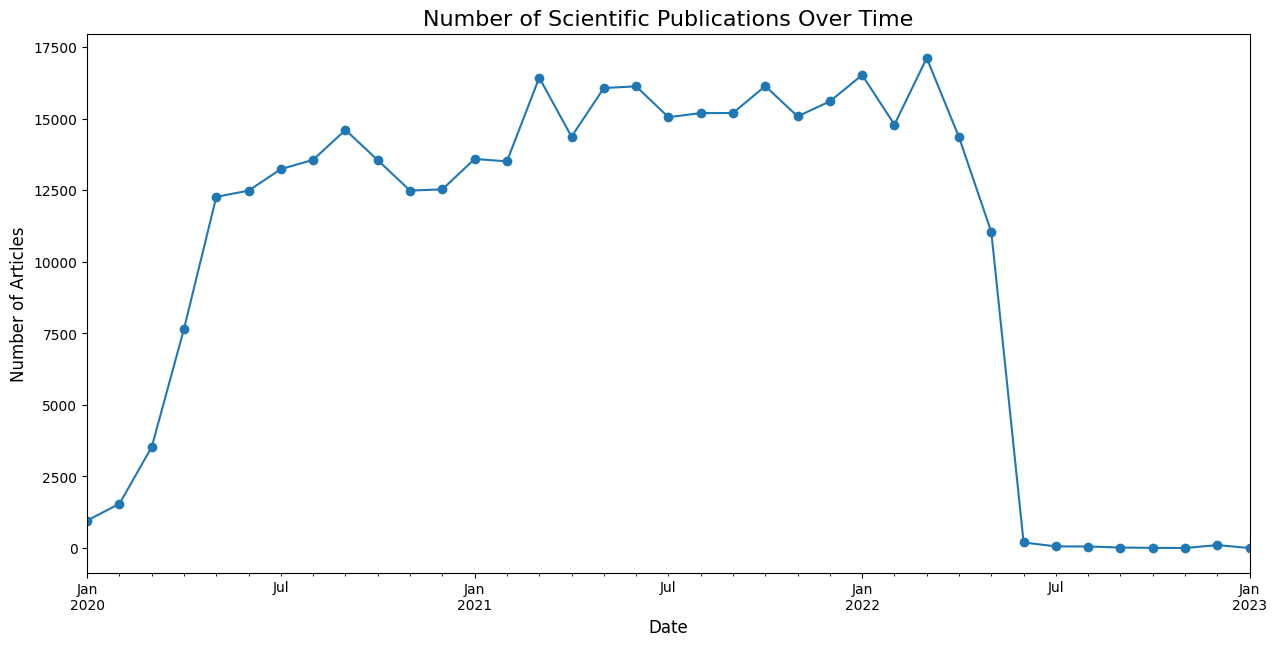

In [24]:
# --- Calculate monthly publication counts ---
df['publish_month'] = df['publish_time'].dt.to_period('M')
monthly_counts = df['publish_month'].value_counts().sort_index()

# --- Plot the graph ---
plt.figure(figsize=(15, 7))
monthly_counts.plot(kind='line', marker='o')
plt.title('Number of Scientific Publications Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.show()

## b) Top Journals by Publication Count
**What we are doing:**

We are identifying which scientific journals published the most articles on COVID-19. This reveals the most influential and active outlets in the field.

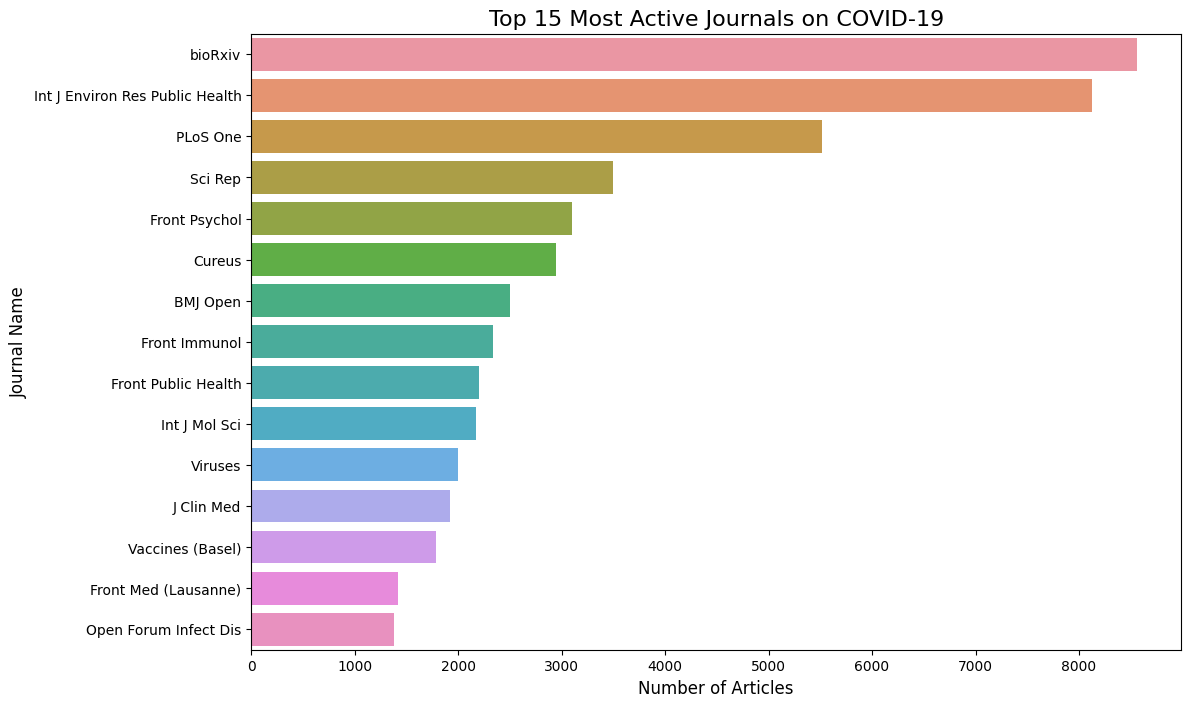

In [25]:
# --- Find the top 15 most active journals ---
top_journals = df['journal'].value_counts().nlargest(15)

# --- Plot the graph ---
plt.figure(figsize=(12, 8))
sns.barplot(x=top_journals.values, y=top_journals.index)
plt.title('Top 15 Most Active Journals on COVID-19', fontsize=16)
plt.xlabel('Number of Articles', fontsize=12)
plt.ylabel('Journal Name', fontsize=12)
plt.show()

# 3. Text Preprocessing
**Why we are doing this:**

This is one of the most critical steps in any NLP project. Computers don't understand text in the same way humans do. To make their job easier, we must clean the "noise" (like punctuation and common filler words) from the text. This allows the computer to focus only on the words that carry significant meaning.

**What we are doing:**
* We will write a function called preprocess_text to perform the following steps:
* Convert all text to lowercase.
* Remove punctuation and numbers.
* Remove common, meaningless words (stopwords like "the", "a", "is").
* Reduce words to their root form (lemmatization, e.g., "studies" becomes "study").

In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower() # 1. Lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text) # 2. Remove punctuation and numbers
    tokens = word_tokenize(text) # 3. Tokenize into words
    # 4. Remove stopwords and lemmatize
    clean_tokens = [
        lemmatizer.lemmatize(word) for word in tokens 
        if word not in stop_words and len(word) > 2
    ]
    return " ".join(clean_tokens)

df['full_text'] = df['title'] + " " + df['abstract']

df['clean_text'] = df['full_text'].apply(preprocess_text)
print("Preprocessing complete!")

# --- Check the result ---
print("\nOriginal Text Example:\n", df['full_text'].iloc[10])
print("\nCleaned Text Example:\n", df['clean_text'].iloc[10])

Preprocessing complete!

Original Text Example:
 Clinical characteristics of patients with pneumonia caused by Klebsiella pneumoniae in Taiwan and prevalence of antimicrobial-resistant and hypervirulent strains: a retrospective study BACKGROUND: We aimed to compare the clinical characteristics of patients with community-acquired pneumonia (CAP), healthcare-associated pneumonia (HCAP), and hospital-acquired pneumonia (HAP) caused by Klebsiella pneumoniae and analyze the antimicrobial resistance and proportion of hypervirluent strains of the microbial isolates. METHODS: We conducted a retrospective study on patients with pneumonia caused by K. pneumoniae at the Taipei Veterans General Hospital in Taiwan between January 2014 and December 2016. To analyze the clinical characteristics of these patients, data was extracted from their medical records. K. pneumoniae strains were subjected to antimicrobial susceptibility testing, capsular genotyping and detection of the rmpA and rmpA2 genes to 

# **4. N-gram Frequency Analysis**

**Why we are doing this:**

To better understand the most commonly discussed concepts in the research papers, we analyze the frequency of individual words (unigrams) and word pairs (bigrams). This helps us identify meaningful patterns, topics, or repeated phrases across the corpus.

**What we are doing:**

1. Define a function to compute and visualize the most frequent n-grams (e.g., single words or two-word combinations).
2. Use `CountVectorizer` to convert the text corpus into a matrix of token counts.
3. Sort the n-grams by frequency and visualize the top 20 using bar charts.

We perform this for:
- **Unigrams** (single words), which highlight the most basic terms used frequently in the dataset.
- **Bigrams** (two-word phrases), which provide more context and help detect meaningful word combinations like "public health", "covid pandemic", etc.

These insights will guide our understanding of the dataset before moving into more advanced NLP tasks like topic modeling or classification.


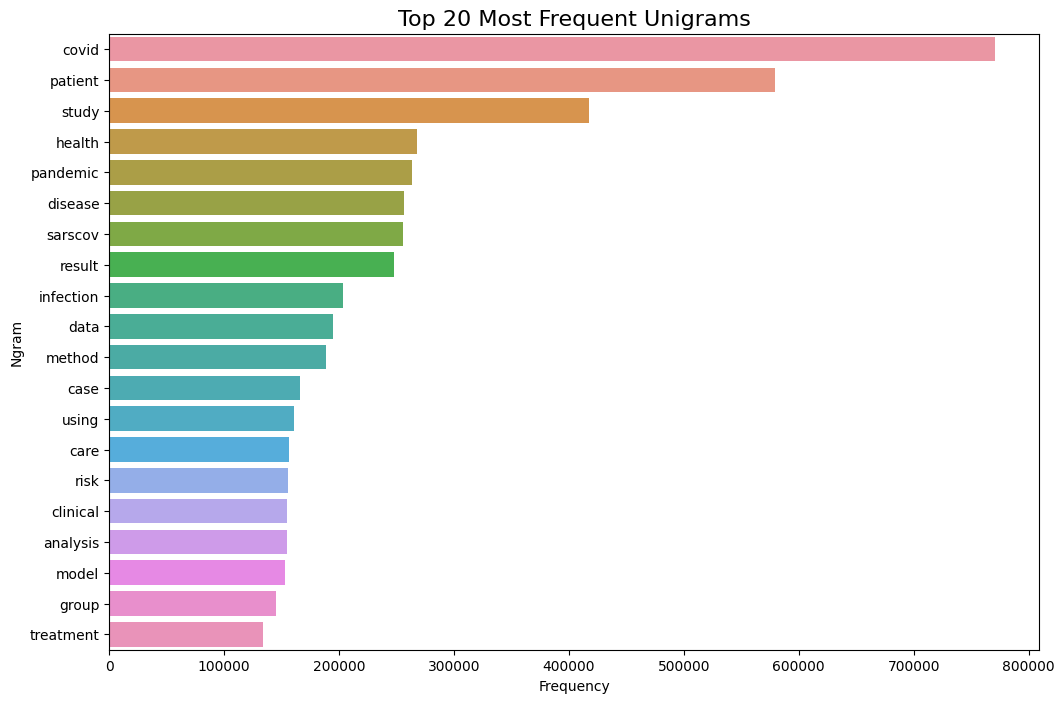

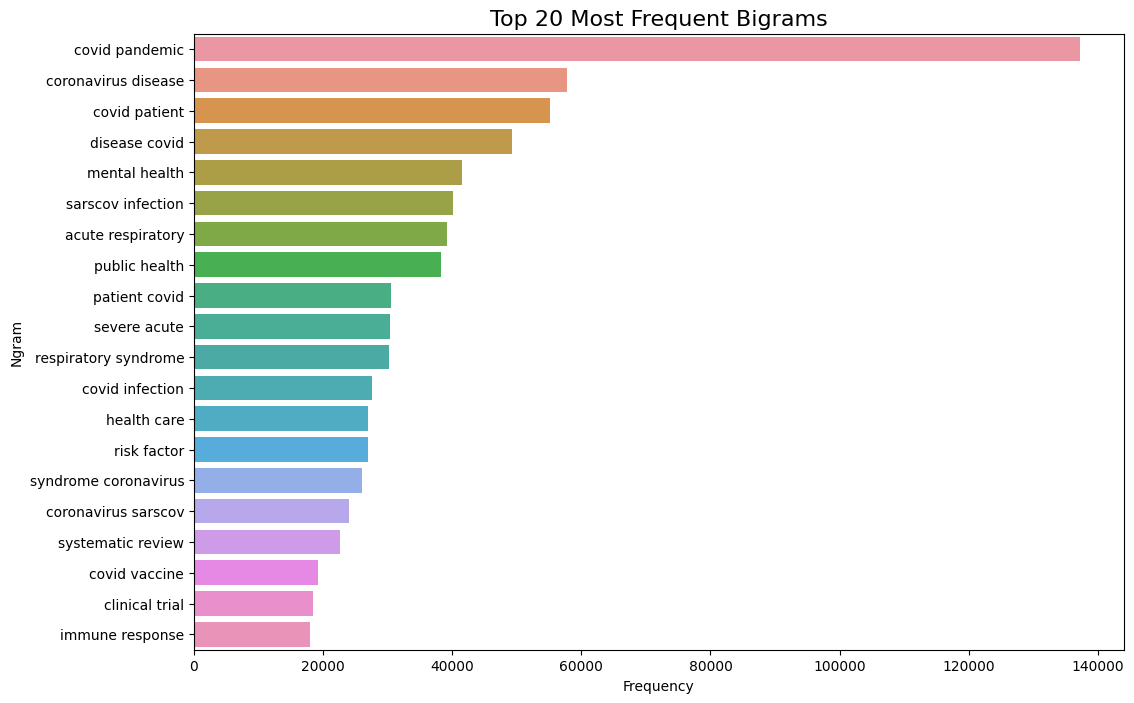

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(corpus, n, ngram_range):
    """
    A function to plot the top n most frequent n-grams in a text corpus.
    """
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    top_df = pd.DataFrame(words_freq[:n], columns=['Ngram', 'Frequency'])
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Frequency', y='Ngram', data=top_df)
    
    ngram_type = "Unigrams" if ngram_range == (1,1) else "Bigrams"
    plt.title(f'Top {n} Most Frequent {ngram_type}', fontsize=16)
    plt.show()

# Plot the top 20 most frequent single words (unigrams)
plot_top_ngrams(corpus=df['clean_text'], n=20, ngram_range=(1,1))

# Plot the top 20 most frequent two-word phrases (bigrams)
plot_top_ngrams(corpus=df['clean_text'], n=20, ngram_range=(2,2))